In [93]:
datasets = ['CUB', 'Derm7pt', 'RIVAL10']
use_dataset = datasets[2]

In [94]:
import os
import sys
import torch
import joblib

notebook_dir = os.getcwd()
project_root_path = os.path.dirname(notebook_dir)
sys.path.insert(0, project_root_path)

from src.config import PROJECT_ROOT, CUB_CONFIG, DERM7PT_CONFIG, RIVAL10_CONFIG  # noqa: E402
import numpy as np  # noqa: E402

In [95]:
if use_dataset == 'CUB':
    config_dict = CUB_CONFIG
    DATASET_PATH =  os.path.join(PROJECT_ROOT, 'output', 'intervention', 'CUB')
elif use_dataset == 'Derm7pt':
    config_dict = DERM7PT_CONFIG
    DATASET_PATH =  os.path.join(PROJECT_ROOT, 'output', 'intervention', 'Derm7pt')
else:
    config_dict = RIVAL10_CONFIG
    DATASET_PATH =  os.path.join(PROJECT_ROOT, 'output', 'intervention', 'RIVAL10')

In [96]:
num_concepts = config_dict['N_TRIMMED_CONCEPTS']
num_classes = config_dict['N_CLASSES']

In [97]:
device = torch.device("cuda" if torch.cuda.is_available()
                    else "mps" if torch.backends.mps.is_available()
                    else "cpu")
print(f"Using device: {device}")

Using device: mps


# Load and Transform Data

In [98]:
lin_C_hat_wrong = np.load(os.path.join(DATASET_PATH, 'C_hat_linear.npy'))
lin_Y = np.load(os.path.join(DATASET_PATH, 'Y_linear.npy'))
lin_model = joblib.load(os.path.join(DATASET_PATH, 'lin_model.joblib'))

clc_C_hat_wrong = torch.load(os.path.join(DATASET_PATH, 'C_hat_clc.npy'))
clc_Y_wrong = torch.load(os.path.join(DATASET_PATH, 'Y_clc.npy'))
clc_model = torch.load(os.path.join(DATASET_PATH, 'clc_model.pth'), weights_only=False, map_location=device)

In [99]:
lin_model.score(lin_C_hat_wrong, lin_Y)

0.0

In [100]:
Y_pred = clc_model.predict(clc_C_hat_wrong)
(Y_pred == clc_Y_wrong).sum().item()/len(Y_pred)

0.0

# Calculate Gain of Each Concept per Model

## Logistic Regression Concept Gain

In [101]:
def compute_intervention_matrices(model, C_hat, Y_test):
    model_weights = model.coef_

    concept_gain_rankings = np.zeros_like(C_hat)
    expected_values = np.zeros_like(C_hat)

    for instance_idx, concept_vector in enumerate(C_hat):
        true_label = Y_test[instance_idx]
        class_weights = model_weights[true_label]
        concept_gains = np.zeros(len(class_weights))
        instance_expected_vals = np.zeros(len(class_weights))

        for concept_idx, concept_weight in enumerate(class_weights):
            # Binary value based on concept weight direction
            expected_concept_value = 1 if concept_weight > 0 else 0
            instance_expected_vals[concept_idx] = expected_concept_value

            # Calculate gain by comparing expected vs pred label, scaled by weight
            concept_gains[concept_idx] = ((expected_concept_value - true_label) * concept_weight)

        expected_values[instance_idx] = instance_expected_vals
        concept_gain_rankings[instance_idx] = (concept_gains)

    concept_indices_by_gain = np.argsort(concept_gain_rankings, axis=1)[:, ::-1]

    return concept_indices_by_gain, expected_values

concept_indices_by_gain, expected_values = compute_intervention_matrices(lin_model, lin_C_hat_wrong, lin_Y)

In [102]:
def intervene(C_hat, expected_values, concept_indices_by_gain, concept_idx=0):
    max_gain_indices = concept_indices_by_gain[:, concept_idx]

    row_indices = np.arange(len(C_hat))
    C_hat[row_indices, max_gain_indices].shape

    updated_C_hat = C_hat
    updated_C_hat[row_indices, max_gain_indices] = expected_values[row_indices, max_gain_indices]

    return updated_C_hat

In [103]:
# updated_C_hat = intervene(lin_C_hat_wrong, expected_values, concept_indices_by_gain)
# lin_accuracy = lin_model.score(updated_C_hat, lin_Y)

In [104]:
C_hat_intervened = lin_C_hat_wrong.copy() # Work on a copy
num_instances = C_hat_intervened.shape[0]
num_concepts = C_hat_intervened.shape[1]

# Calculate initial accuracy on this subset
initial_predictions = lin_model.predict(C_hat_intervened)
misclassified_mask = (initial_predictions != lin_Y)

accuracy = lin_model.score(C_hat_intervened, lin_Y)
accuracies = [accuracy]
# print(f"0: Accuracy {accuracy:.4f}, Misclassified count: {np.sum(misclassified_mask)}")

intervention_step = 0
while np.any(misclassified_mask) and intervention_step < num_concepts:
    # Get the indices of instances that are currently misclassified
    indices_to_intervene = np.where(misclassified_mask)[0]

    if len(indices_to_intervene) == 0: # Should be caught by np.any(misclassified_mask)
        print("All instances in the subset are now correctly classified.")
        break

    # Select which concept to intervene on for each misclassified instance
    concepts_to_change_for_these_instances = concept_indices_by_gain[indices_to_intervene, intervention_step]

    # Apply the intervention by setting concepts to their expected values
    C_hat_intervened[indices_to_intervene, concepts_to_change_for_these_instances] = \
        expected_values[indices_to_intervene, concepts_to_change_for_these_instances]

    # Re-evaluate after intervention
    current_predictions = lin_model.predict(C_hat_intervened)
    misclassified_mask = (current_predictions != lin_Y)
    accuracy = lin_model.score(C_hat_intervened, lin_Y)
    accuracies.append(accuracy)

    # print(f"{intervention_step + 1}: Accuracy {accuracy:.4f}, Misclassified count: {np.sum(misclassified_mask)}")

    intervention_step += 1

print(f"Stopped after {intervention_step} concept interventions.")
print(f"Final accuracy: {accuracies[-1]:.4f}")

Stopped after 17 concept interventions.
Final accuracy: 1.0000


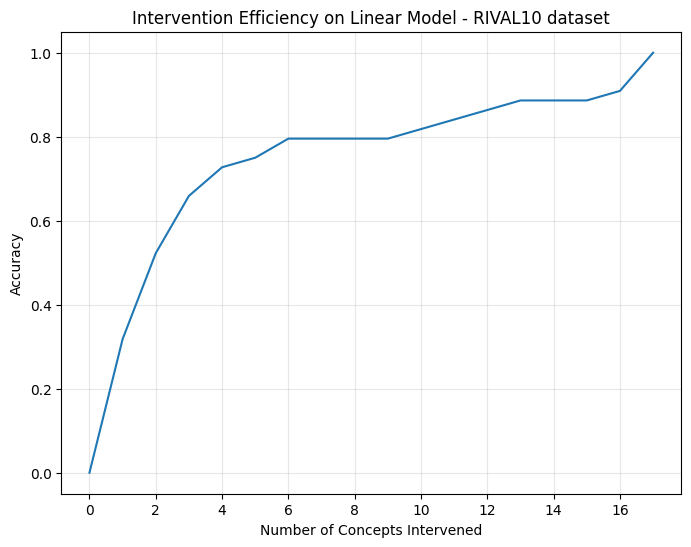

In [105]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(np.arange(len(accuracies)), accuracies)
plt.xlabel("Number of Concepts Intervened")
plt.ylabel("Accuracy")
plt.title(f"Intervention Efficiency on Linear Model - {use_dataset} dataset")
plt.grid(alpha=0.3)

if use_dataset == 'CUB':
    pass
if use_dataset == 'Derm7pt':
    x_ticks = np.arange(0, len(accuracies), 2)
    plt.xticks(x_ticks, x_ticks.astype(int))
if use_dataset == 'RIVAL10':
    x_ticks = np.arange(0, len(accuracies), 2)
    plt.xticks(x_ticks, x_ticks.astype(int))

plt.show()

## Prototypes Intervention

In [106]:
prototypes = clc_model.get_binary_prototypes()

gain_matrix = np.zeros((clc_C_hat_wrong.shape[0], clc_C_hat_wrong.shape[1]))
expected_values = np.zeros((clc_C_hat_wrong.shape[0], clc_C_hat_wrong.shape[1]))

for instance_idx, concept_vector in enumerate(clc_C_hat_wrong):
    pred_label = clc_Y_wrong[instance_idx]
    prototype = prototypes[pred_label].cpu().detach().numpy()
    gain_vector = np.abs(prototype-concept_vector.cpu().detach().numpy())
    gain_matrix[instance_idx] = gain_vector
    expected_values[instance_idx] = prototype

concept_indices_by_gain = np.argsort(gain_matrix, axis=1)[:, ::-1]
expected_values = torch.tensor(expected_values, device=device, dtype=torch.float32)

In [107]:
# updated_C_hat = intervene(clc_C_hat_wrong, expected_values, concept_indices_by_gain)

In [108]:
# Y_pred = clc_model.predict(updated_C_hat)
# (Y_pred == clc_Y_wrong).sum().item()/len(Y_pred)

In [ ]:
# Initialize intervention data and move to appropriate device
C_hat_intervened_proto = clc_C_hat_wrong.clone().detach()
Y_true_proto_device = clc_Y_wrong.to(C_hat_intervened_proto.device)

# Get initial predictions and identify misclassified instances
with torch.no_grad():
    initial_predictions_proto = clc_model.predict(C_hat_intervened_proto)

misclassified_mask_proto = (initial_predictions_proto != Y_true_proto_device)

current_accuracy_proto = (~misclassified_mask_proto).float().mean().item()
accuracies = [current_accuracy_proto]

# print(f"Prototypes - Initial: Accuracy {current_accuracy_proto:.4f}, Misclassified count: {misclassified_mask_proto.sum().item()}")

intervention_step_proto = 0
while misclassified_mask_proto.any() and intervention_step_proto < clc_C_hat_wrong.shape[1]:
    indices_to_intervene_proto = torch.where(misclassified_mask_proto)[0]

    if len(indices_to_intervene_proto) == 0: # Should be caught by misclassified_mask_proto.any()
        print("Prototypes - All instances in the subset are now correctly classified.")
        break

    # Select which concept to intervene on for each misclassified instance
    concepts_to_change_for_these_instances_np = concept_indices_by_gain[
        indices_to_intervene_proto.cpu().numpy(),
        intervention_step_proto
    ]

    # Apply the intervention by setting concepts to their expected values
    C_hat_intervened_proto[indices_to_intervene_proto, concepts_to_change_for_these_instances_np] = \
        expected_values[indices_to_intervene_proto, concepts_to_change_for_these_instances_np]

    # Re-evaluate after intervention
    with torch.no_grad():
        current_predictions_proto = clc_model.predict(C_hat_intervened_proto)

    misclassified_mask_proto = (current_predictions_proto != Y_true_proto_device) # Update mask
    current_accuracy_proto = (~misclassified_mask_proto).float().mean().item()
    accuracies.append(current_accuracy_proto)

    # print(f"Prototypes - Intervention {intervention_step_proto + 1}: Accuracy {current_accuracy_proto:.4f}, Misclassified count: {misclassified_mask_proto.sum().item()}")

    intervention_step_proto += 1

print(f"Prototypes - Stopped after {intervention_step_proto} rounds of concept interventions.")
print(f"Prototypes - Final accuracy: {accuracies[-1]:.4f}")

Prototypes - Stopped after 4 rounds of concept interventions.
Prototypes - Final accuracy: 1.0000


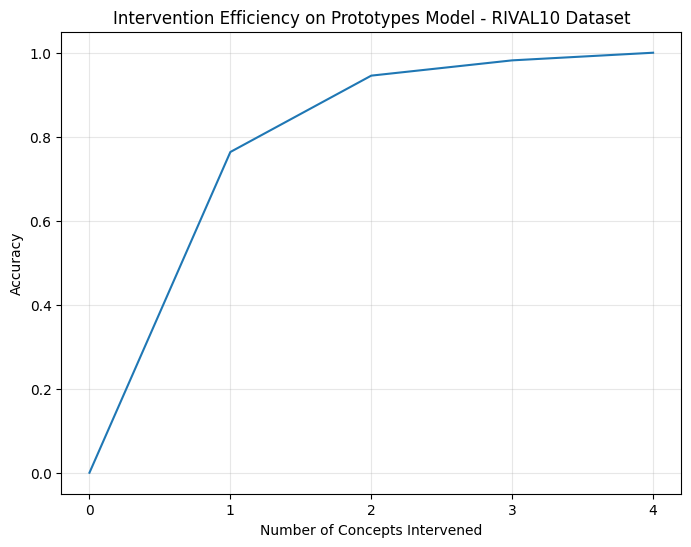

In [110]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(accuracies)), accuracies)
plt.xlabel("Number of Concepts Intervened")
plt.ylabel("Accuracy")
plt.title(f"Intervention Efficiency on Prototypes Model - {use_dataset} Dataset")
plt.grid(alpha=0.3)

if use_dataset == 'CUB':
    pass
if use_dataset == 'Derm7pt':
    x_ticks = np.arange(0, len(accuracies), 2)
    plt.xticks(x_ticks, x_ticks.astype(int))
if use_dataset == 'RIVAL10':
    x_ticks = np.arange(0, len(accuracies))
    plt.xticks(x_ticks, x_ticks.astype(int))

plt.show()

# analysis of incorrect classifications

In [111]:
# # Sort concept gains in descending order for each instance
# sorted_concept_gains = np.sort(concept_gain_rankings, axis=1)[:, ::-1]

# # Display the shape and the first few examples
# print(f"Shape of sorted gains: {sorted_concept_gains.shape}")
# print("Top 5 highest gains for first 3 instances:")
# print(sorted_concept_gains[:100, :5])  # First 3 instances, top 5 gains

# # If you need the indices of the concepts in descending order
# concept_indices_by_gain = np.argsort(concept_gain_rankings, axis=1)[:, ::-1]
# print("\nIndices of concepts with highest gains (first 3 instances):")
# print(concept_indices_by_gain[:100, :5])  # First 3 instances, indices of top 5 concepts

In [112]:
# unique_classes, counts = np.unique(lin_Y_wrong, return_counts=True)
# print(dict(zip(unique_classes, counts)))

In [113]:
# import seaborn as sns

# import matplotlib.pyplot as plt

# # Create a more readable format of the class distribution
# class_distribution = dict(zip(unique_classes, counts))

# # Plot settings
# plt.figure(figsize=(15, 6))
# sns.set_style("whitegrid")

# # Create the bar plot
# plt.bar(range(len(class_distribution)), list(class_distribution.values()), color='skyblue', edgecolor='navy', alpha=0.7)

# # Add labels and title
# plt.xlabel('Class Index', fontsize=12)
# plt.ylabel('Count of Incorrect Predictions', fontsize=12)
# plt.title('Distribution of Incorrect Predictions Across Classes in CUB Dataset', fontsize=14)

# # Only show a subset of x-ticks to avoid overcrowding
# x_ticks = range(0, len(class_distribution), 10)
# plt.xticks(x_ticks, [unique_classes[i] for i in x_ticks])

# # Add total count information
# total_incorrect = sum(counts)
# plt.text(len(class_distribution)/2, max(counts)*0.9, f'Total Incorrect Predictions: {total_incorrect}',
#          horizontalalignment='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

# plt.tight_layout()
# plt.show()

In [114]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# corr_matrix = np.corrcoef(lin_C_hat_wrong, rowvar=False)
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
# plt.title('Concept Correlation Matrix')
# plt.show()

In [115]:
# plt.figure(figsize=(10, 6))
# plt.hist(model_weights.flatten(), bins=50)
# plt.title('Distribution of Model Weights')
# plt.xlabel('Weight Value')
# plt.ylabel('Frequency')
# plt.show()